In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import OlmoForCausalLM, AutoTokenizer, GPTNeoXForCausalLM, AutoModelForCausalLM
from src.to_numpy import to_numpy
from src.model_wrapper import ModelWrapper
from src.hook import Hook, RecordHook, ZeroOutAttentionHeadHook, CompositeHook
from src.model_wrapper import ModelWrapper
torch.set_printoptions(sci_mode=False)
import os

/data/tianyu/miniconda3/envs/dormant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/tianyu/miniconda3/envs/dormant/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
device = "cuda:2"

In [3]:
model_name_olmo = "allenai/OLMo-7B-0424-hf"

revisions_olmo = [
    (0, "step0-tokens0B"),
    (500, "step500-tokens2B"),
    (1000, "step1000-tokens4B"),
    (1500, "step1500-tokens6B"),
    (2000, "step2000-tokens8B"),
    (2500, "step2500-tokens10B"),
    (3000, "step3000-tokens12B"),
    (3500, "step3500-tokens14B"),
    (4000, "step4000-tokens16B"),
    (4500, "step4500-tokens18B"),
    (5000, "step5000-tokens20B"),
    (5500, "step5500-tokens23B"),
    (6000, "step6000-tokens25B"),
    (6500, "step6500-tokens27B"),
    (7000, "step7000-tokens29B"),
    (7500, "step7500-tokens31B"),
    (8000, "step8000-tokens33B"),
    (8500, "step8500-tokens35B"),
    (9000, "step9000-tokens37B"),
    (9500, "step9500-tokens39B"),
    (10000, "step10000-tokens41B"),
    (25000, "step25000-tokens104B"),
    (50000, "step50000-tokens209B"),
    (100000, "step100000-tokens419B"),
    (147500, "step147500-tokens618B"),
    (200000, "step200000-tokens838B"),
    (250000, "step250000-tokens1048B"),
    (300000, "step300000-tokens1257B"),
    (350000, "step350000-tokens1467B"),
    (400000, "step410000-tokens1719B"),
    (450000, "step449000-tokens1882B")
]

def load_olmo_model(revision):
    model = AutoModelForCausalLM.from_pretrained(model_name_olmo, revision=revision[1], attn_implementation="eager", trust_remote_code=True, device_map=device)
    model.eval()
    model.requires_grad_(False)
    return ModelWrapper(model)

tokenizer = AutoTokenizer.from_pretrained(model_name_olmo, trust_remote_code=True)

In [4]:
def collect_statistics_at_layer(model_wrapper, input_tokens, layer_probe):
    layer_input_prenorm_hook = RecordHook(target_name="layer_input_prenorm", record_buffer=[], target_layers=[layer_probe])
    layer_input_postnorm_hook = RecordHook(target_name="layer_input_postnorm", record_buffer=[], target_layers=[layer_probe])
    q_hook = RecordHook(target_name="q_proj", record_buffer=[], target_layers=[layer_probe])
    k_hook = RecordHook(target_name="k_proj", record_buffer=[], target_layers=[layer_probe])
    v_hook = RecordHook(target_name="v_proj", record_buffer=[], target_layers=[layer_probe])
    q_postrope_hook = RecordHook(target_name="q_proj_postrope", record_buffer=[], target_layers=[layer_probe])
    k_postrope_hook = RecordHook(target_name="k_proj_postrope", record_buffer=[], target_layers=[layer_probe])
    v_postrope_hook = RecordHook(target_name="v_proj_postrope", record_buffer=[], target_layers=[layer_probe])
    attn_logits_hook = RecordHook(target_name="attn_logits", record_buffer=[], target_layers=[layer_probe])
    attn_weights_hook = RecordHook(target_name="attn_weights", record_buffer=[], target_layers=[layer_probe])
    attn_softmax_qkt_v_hook = RecordHook(target_name="attn_softmax_qkt_v", record_buffer=[], target_layers=[layer_probe])
    attn_output_hook = RecordHook(target_name="attn_output", record_buffer=[], target_layers=[layer_probe])
    post_attn_residual_hook = RecordHook(target_name="post_attn_residual", record_buffer=[], target_layers=[layer_probe])
    post_attn_postnorm_hook = RecordHook(target_name="post_attn_postnorm", record_buffer=[], target_layers=[layer_probe])
    post_mlp_residual_hook = RecordHook(target_name="post_mlp_residual", record_buffer=[], target_layers=[layer_probe])
    hook = CompositeHook(hooks=[layer_input_prenorm_hook, layer_input_postnorm_hook, q_hook, k_hook, v_hook, q_postrope_hook, k_postrope_hook, v_postrope_hook, attn_logits_hook, attn_weights_hook, attn_softmax_qkt_v_hook, attn_output_hook, post_attn_residual_hook, post_attn_postnorm_hook, post_mlp_residual_hook])
    model_wrapper.forward(input_tokens, hook=hook)
    return {
        "layer_input_prenorm": layer_input_prenorm_hook.record_buffer[0],
        "layer_input_postnorm": layer_input_postnorm_hook.record_buffer[0],
        "q_proj": q_hook.record_buffer[0],
        "k_proj": k_hook.record_buffer[0],
        "v_proj": v_hook.record_buffer[0],
        "q_proj_postrope": q_postrope_hook.record_buffer[0],
        "k_proj_postrope": k_postrope_hook.record_buffer[0],
        "v_proj_postrope": v_postrope_hook.record_buffer[0],
        "attn_logits": attn_logits_hook.record_buffer[0],
        "attn_weights": attn_weights_hook.record_buffer[0],
        "attn_softmax_qkt_v": attn_softmax_qkt_v_hook.record_buffer[0],
        "attn_output": attn_output_hook.record_buffer[0],
        "post_attn_residual": post_attn_residual_hook.record_buffer[0],
        "post_attn_postnorm": post_attn_postnorm_hook.record_buffer[0],
        "post_mlp_residual": post_mlp_residual_hook.record_buffer[0],
    }
    

In [5]:
def plot_heatmap_per_head(scores, layer_probe, title, xlabel, ylabel, use_01_colorscheme=False):
    sns.set_theme(style="white")
    scores = to_numpy(scores)

    # Visualize each slice in the index 1 as a separate seaborn heatmap
    num_heads = scores.shape[0]
    assert num_heads == 32
    rows, cols = 4, 8
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
    axes = axes.flatten()
    fig.suptitle(title)

    for head in range(num_heads):
        if use_01_colorscheme:
            sns.heatmap(scores[head], cmap="Blues", ax=axes[head], mask=scores[head] == 0, vmin=0, vmax=1)
        else:
            sns.heatmap(scores[head], cmap="Blues",  ax=axes[head], mask=scores[head] == 0)
        axes[head].set_title(f"L{layer_probe}H{head}")
        axes[head].set_xlabel(xlabel)
        axes[head].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()
    #sns.set_theme()

In [6]:
batch_size = 1
num_extra_tokens = 1

In [7]:
input_text = "Summer is warm. Winter is cold."
input_tokens = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
print(input_tokens.shape)
print(tokenizer.decode(input_tokens.cpu().tolist()[0], clean_up_tokenization_spaces=False))

torch.Size([1, 8])
Summer is warm. Winter is cold.


In [8]:
torch.save(input_tokens, "input_tokens.pt")
input_tokens = torch.load("input_tokens.pt").to(device)
layer = 24

/tmp/ipykernel_641824/2759737704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tokens = torch.load("input_tokens.pt").to(device)


Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/internal/generation_utils#transformers.Cache)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([1, 32, 8, 8])


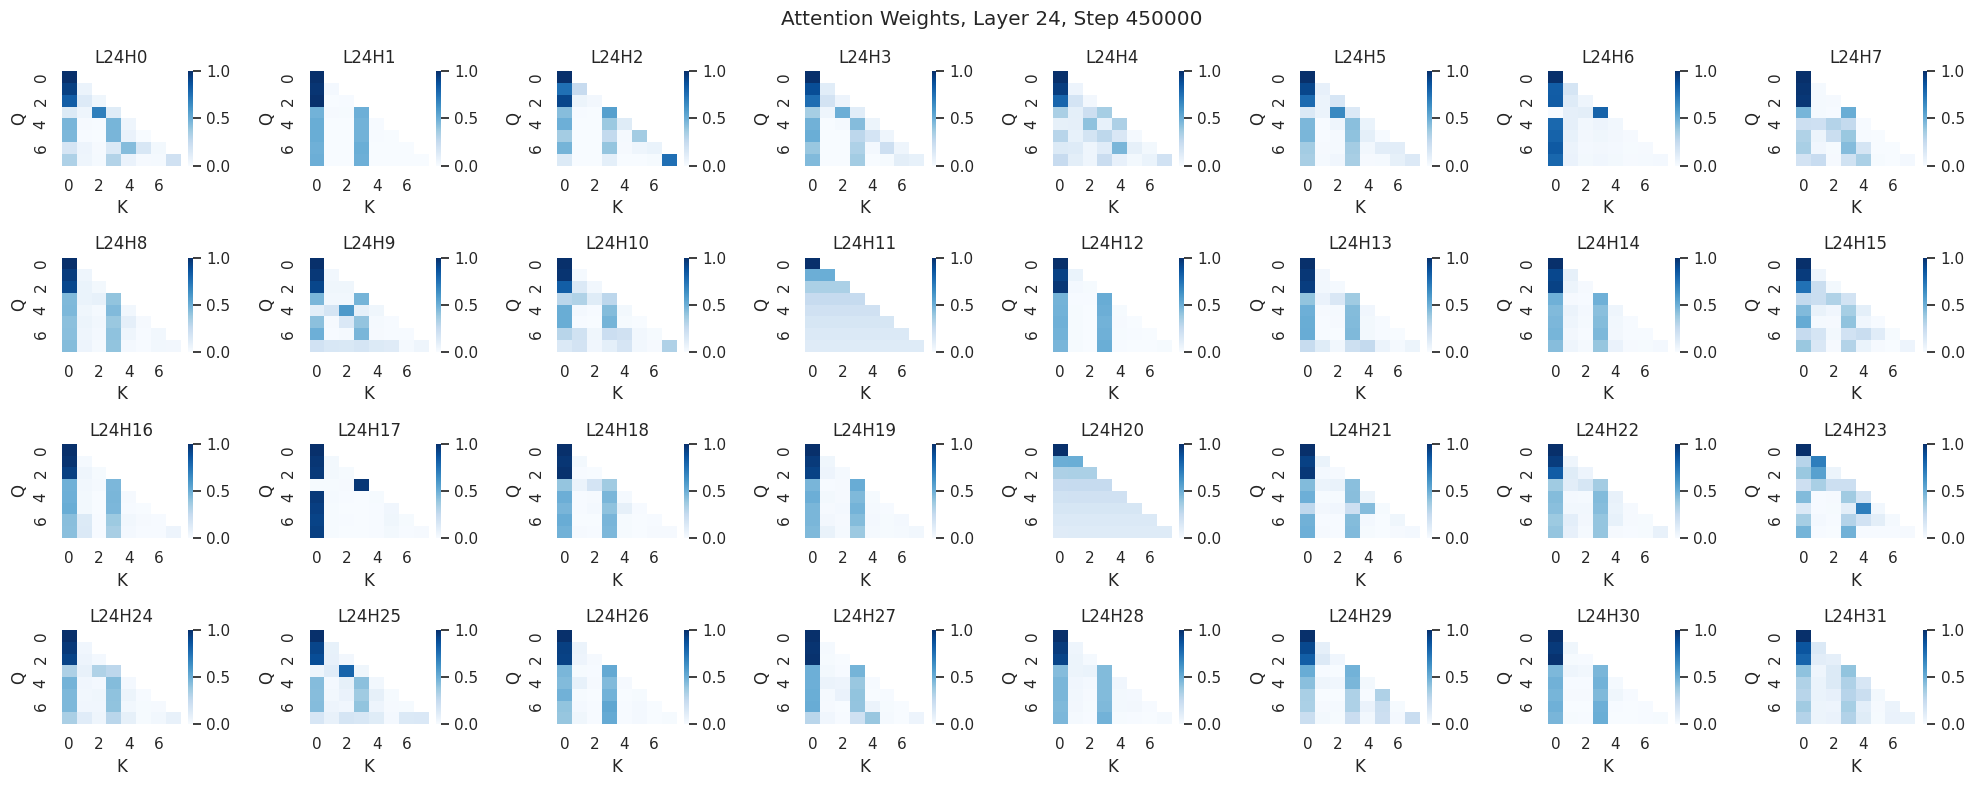

In [9]:
model = load_olmo_model(revisions_olmo[-1])
stats = collect_statistics_at_layer(model, input_tokens, layer_probe=layer)
print(stats["attn_weights"].shape)
plot_heatmap_per_head(stats["attn_weights"][0], layer, f"Attention Weights, Layer {layer}, Step {revisions_olmo[-1][0]}", "K", "Q", use_01_colorscheme=True)

del model 
del stats 
torch.cuda.empty_cache()

In [35]:
print(input_tokens.shape)

torch.Size([1, 8])


In [36]:
recompute = False

if recompute:
    from torch.functional import F
    dir_name = "./pretrain_summer"
    attn_weights = {}
    attn_logits = {}
    qs = {}
    ks = {}
    vs = {}
    layer_outputs = {}
    from tqdm import tqdm
    import os

    for revision in revisions_olmo:
        model = load_olmo_model(revision)
        stats = collect_statistics_at_layer(model, input_tokens, layer_probe=layer)
        attn_weights[revision] = stats["attn_weights"]
        attn_logits[revision] = stats["attn_logits"]
        qs[revision] = stats["q_proj_postrope"]
        ks[revision] = stats["k_proj_postrope"]
        vs[revision] = stats["v_proj_postrope"]
        attn = model.model.model.layers[24].self_attn
        o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
        vo_head = torch.stack([F.linear(vs[revision][0:1, i, ...], o_split[i]) for i in range(attn.num_heads)], dim=1)
        vs[revision] = vo_head
        layer_outputs[revision] = stats["post_mlp_residual"]
        del model
        del stats
        print(revision)
    torch.save(attn_weights, os.path.join(dir_name, "attn_weights.pt"))
    torch.save(attn_logits,  os.path.join(dir_name, "attn_logits.pt"))
    torch.save(qs, os.path.join(dir_name, "qs.pt"))
    torch.save(ks, os.path.join(dir_name, "ks.pt"))
    torch.save(vs, os.path.join(dir_name, "vs.pt"))
    torch.save(layer_outputs, os.path.join(dir_name, "layer_outputs.pt"))

In [37]:
# model = load_olmo_model(revision)
# from torch.functional import F
# attn = model.model.model.layers[24].self_attn
# o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
# vo_head = torch.stack([F.linear(vs[revision][0:1, i, ...], o_split[i]) for i in range(attn.num_heads)], dim=1)

In [38]:
def plt_configure_x_axis(scale):
    if scale == "symlog":
        plt.xscale('symlog', linthresh=10000, linscale=1, base=10)
        plt.xticks(ticks=[0, 2_500, 5_000, 7_500, 10_000, 25_000, 50_000, 100_000, 200_000, 400_000], labels=[r"$0$", r"$2500$", r"$5000$", r"$7500$", r"$10000 = 10^4$", r"$2.5 \times 10^4$", r"$5 \times 10^4$", r"$10^5$", r"$2 \times 10^5$", r"$4 \times 10^5$"])
    plt.xlim(0, max([revision[0] for revision in revisions_olmo]))

# torch.save(attn_weights, "attn_weights.pt")
# torch.save(attn_logits, "attn_logits.pt")
# torch.save(qs, "qs.pt")
# torch.save(ks, "ks.pt")
# torch.save(vs, "vs.pt")
# torch.save(layer_outputs, "layer_outputs.pt")

In [39]:
dir_name = "./pretrain_summer"

attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"))
attn_logits = torch.load(os.path.join(dir_name, "attn_logits.pt"))
qs = torch.load(os.path.join(dir_name, "qs.pt"))
ks = torch.load(os.path.join(dir_name, "ks.pt"))
vs = torch.load(os.path.join(dir_name, "vs.pt"))
layer_outputs = torch.load(os.path.join(dir_name, "layer_outputs.pt"))

/tmp/ipykernel_641824/1589059502.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"))
/tmp/ipykernel_6418

In [40]:
attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"), map_location=device)
attn_masses_on_k_tokens = {
    revision: attn_weights[revision].sum(dim=-2) / (attn_weights[revision].shape[-2] - torch.arange(attn_weights[revision].shape[-2], device=device)).reshape(1, 1, -1)
    for revision in attn_weights.keys()
}
attn_mass_on_top_token = {
    revision: attn_masses_on_k_tokens[revision].topk(k=1, dim=-1).values.sum(dim=-1)
    for revision in attn_weights.keys()
}
attn_mass_on_top_two_tokens = {
    revision: attn_masses_on_k_tokens[revision].topk(k=2, dim=-1).values.sum(dim=-1)
    for revision in attn_weights.keys()
}
attn_mass_on_second_tokens = {
    revision: attn_masses_on_k_tokens[revision].topk(k=2, dim=-1).values[:, :, 1]
    for revision in attn_weights.keys()
}

/tmp/ipykernel_641824/192714419.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"), map_location=device)

In [41]:
cutoff = 2.5e4
steps = np.array([revision[0] for revision in revisions_olmo])
tmp = steps[steps >= cutoff]
crucial_steps = np.isin(tmp, [cutoff, 1e5, 4e5])
tmp = np.log(tmp)
tmp = tmp - np.min(tmp)
tmp = tmp / np.max(tmp) * cutoff
tmp = tmp + cutoff
steps[steps >= cutoff] = tmp

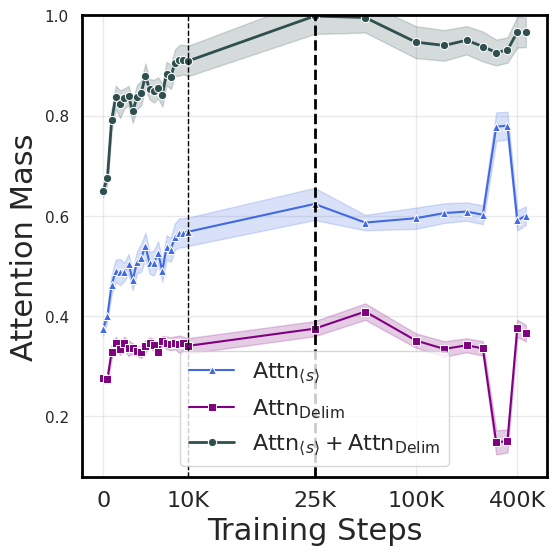

In [42]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")


df_top = pd.DataFrame({"Step": steps, "Attention on Top Token": [to_numpy(attn_mass_on_top_token[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on Top Token")

df_top_two = pd.DataFrame({"Step": steps, "Attention on Top Two Tokens": [to_numpy(attn_mass_on_top_two_tokens[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on Top Two Tokens")

df_second = pd.DataFrame({"Step": steps, "Attention on Second Token": [to_numpy(attn_mass_on_second_tokens[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on Second Token")
#sns.set_theme(style="whitegrid")
sns.lineplot(data=df_top, x="Step", y="Attention on Top Token", errorbar="se", label=r"$\mathrm{Attn}_{\langle s \rangle}$", color="royalblue", marker="^")
sns.lineplot(data=df_second, x="Step", y="Attention on Second Token", errorbar="se", label=r"$\mathrm{Attn}_{\text{Delim}}$", color="purple", marker="s")
sns.lineplot(data=df_top_two, x="Step", y="Attention on Top Two Tokens", errorbar="se", label=r"$\mathrm{Attn}_{\langle s \rangle}+\mathrm{Attn}_{\text{Delim}}$", marker="o", color="darkslategray", linewidth=2)
# plt_configure_x_axis("symlog")
#plt.title(f"Attention Weight Distribution at Layer {layer}")
plt.ylabel(f"Attention Mass", fontsize=22)
plt.xlabel("Training Steps", fontsize=22)
# plt.yticks([0.7, 0.8, 0.9, 1.0], [r"$0.7$", r"$0.8$", r"$0.9$", r"$1.0$"], fontsize=16)
plt.ylim(top=1.0)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
ymin, ymax = ax.get_ylim()

plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)

plt.legend(fontsize=16)
plt.savefig("figures/olmo/attn_mass_on_top_two_tokens.pdf", bbox_inches="tight")
plt.show()

In [43]:
layer_outputs = torch.load(os.path.join(dir_name, "layer_outputs.pt"))
layer_output_norms = {
    revision: layer_outputs[revision].norm(dim=-1)
    for revision in layer_outputs.keys()
}

/tmp/ipykernel_641824/1714451885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  layer_outputs = torch.load(os.path.join(dir_name, "layer_outputs.pt"))


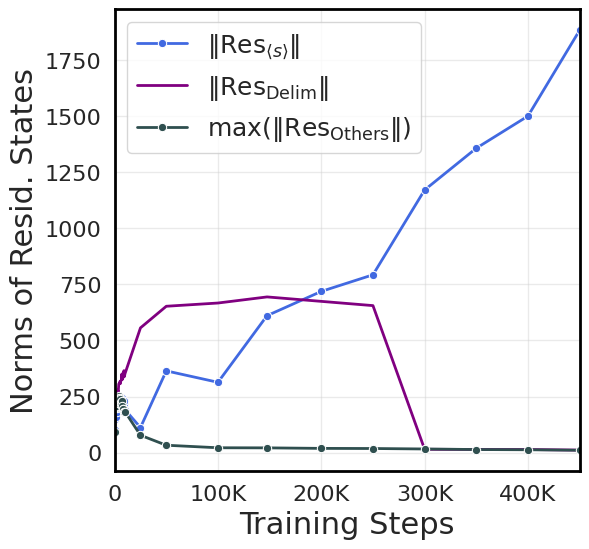

In [44]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")

zeroth_token_norms = {revision: layer_output_norms[revision][:, 0] for revision in layer_output_norms.keys()}
third_token_norms = {revision: layer_output_norms[revision][:, 3] for revision in layer_output_norms.keys()}
mask = torch.ones_like(layer_output_norms[revisions_olmo[-1]], dtype=torch.bool)
mask[:, 0] = 0
mask[:, 3] = 0
max_regular_token_norms = {revision: torch.max(layer_output_norms[revision][mask], dim=-1).values for revision in layer_output_norms.keys()}
df = pd.DataFrame({"Step": [revision[0] for revision in revisions_olmo], "Per-Token Output Norms": [to_numpy(zeroth_token_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Res}_{\langle s \rangle}\|$", color="royalblue", marker="o", linewidth=2)
df = pd.DataFrame({"Step": [revision[0] for revision in revisions_olmo], "Per-Token Output Norms": [to_numpy(third_token_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Res}_{\text{Delim}}\|$", color="purple", linewidth=2)
df = pd.DataFrame({"Step": [revision[0] for revision in revisions_olmo], "Per-Token Output Norms": [to_numpy(max_regular_token_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms")
plt.xlim(0, max([revision[0] for revision in revisions_olmo]))
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\max(\|\mathrm{Res}_{\text{Others}}\|)$", color="darkslategray", marker="o", linewidth=2)
plt.xlabel("Training Steps", fontsize=22)
plt.ylabel("Norms of Resid. States", fontsize=22)
plt.xticks([0, 100_000, 200_000, 300_000, 400_000], [r"$0$", r"100K", r"200K", r"300K", r"400K"], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("figures/olmo/layer_output_norms.pdf", bbox_inches="tight")
plt.show()

In [45]:
attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"))
attn_logits = torch.load(os.path.join(dir_name, "attn_logits.pt"))
attn_logits_valid_mask = {revision: attn_weights[revision] != 0 for revision in attn_logits.keys()}
normalization_mask = {revision: attn_logits_valid_mask[revision].clone() for revision in attn_logits.keys()}
for revision in attn_logits.keys():
    normalization_mask[revision][:, :, 0] = 0
    normalization_mask[revision][:, :, 3] = 0

Qk_0 = {revision: attn_logits[revision][:, :, :, 0] for revision in attn_logits.keys()}
Qk_0_normalized = {revision: 
                   torch.stack(
                       [
                           attn_logits[revision][:, :, q_idx, 0] - torch.mean(attn_logits[revision], dim=-1)[:, :, q_idx]
                           for q_idx in range(attn_logits[revision].shape[-2])
                       ], dim=-1
                   ) for revision in attn_logits.keys()}

/tmp/ipykernel_641824/1052723306.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_weights = torch.load(os.path.join(dir_name, "attn_weights.pt"))
/tmp/ipykernel_6418

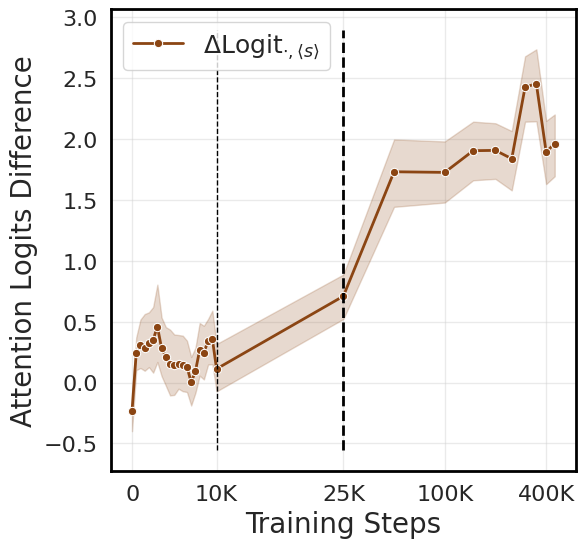

In [46]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")

zeroth_token_logit = {revision: Qk_0_normalized[revision][:, :, 0] for revision in attn_logits.keys()}
third_token_logit = {revision: Qk_0_normalized[revision][:, :, 3] for revision in attn_logits.keys()}

mask = torch.ones_like(Qk_0_normalized[revisions_olmo[-1]], dtype=torch.bool)

max_other_token_logit = {revision: torch.maximum(torch.max(Qk_0_normalized[revision][:, :, 1:3], dim=-1).values, torch.max(Qk_0_normalized[revision][:, :, 4:], dim=-1).values) for revision in attn_logits.keys()}
min_other_token_logit = {revision: torch.minimum(torch.min(Qk_0_normalized[revision][:, :, 1:3], dim=-1).values, torch.min(Qk_0_normalized[revision][:, :, 4:], dim=-1).values) for revision in attn_logits.keys()}
mean_other_token_logit = {revision: (torch.sum(Qk_0_normalized[revision][:, :, 1:3], dim=-1) + torch.sum(Qk_0_normalized[revision][:, :, 4:], dim=-1)) / Qk_0_normalized[revision].shape[-1] for revision in attn_logits.keys()}

# df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(zeroth_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
# sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{0}$", marker="o", linewidth=2, color="royalblue")

# df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(third_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
# sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{3}$", marker="o", linewidth=2, color="purple")

# df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(max_other_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
# sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\max(\Delta\mathrm{Logit}_{i} \colon i \neq 0, 3)$", marker="o", linewidth=2, color="darkslategray")

# df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(min_other_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
# sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\min(\Delta\mathrm{Logit}_{i} \colon i \neq 0, 3)$", marker="o", linewidth=2, color="saddlebrown")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(mean_other_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{\cdot, \langle s \rangle}$", marker="o", linewidth=2, color="saddlebrown")

plt.xlabel("Training Steps", fontsize=20)
# plt.xlim(1, max([revision[0] for revision in revisions_olmo]))
plt.ylabel(f"Attention Logits Difference", fontsize=20)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
ymin, ymax = ax.get_ylim()
plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("figures/olmo/attention_logits.pdf", bbox_inches="tight")
plt.show(fig)


/tmp/ipykernel_641824/1114303834.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vs = torch.load(os.path.join(dir_name, "vs.pt"))


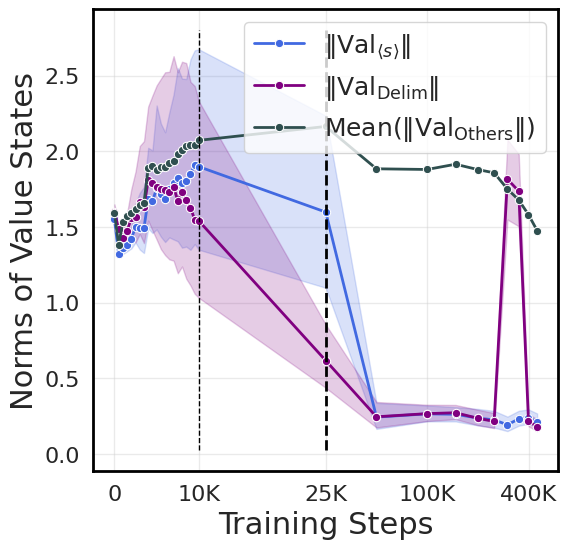

In [48]:
vs = torch.load(os.path.join(dir_name, "vs.pt"))
v_norms = {revision: vs[revision].norm(dim=-1) for revision in vs.keys()}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")


zeroth_token_v_norm = {revision: v_norms[revision][:, :, 0] for revision in v_norms.keys()}
third_token_v_norm = {revision: v_norms[revision][:, :, 3] for revision in v_norms.keys()}

mask = torch.ones_like(v_norms[revisions_olmo[-1]], dtype=torch.bool)
max_other_token_v_norm = {revision: torch.maximum(torch.max(v_norms[revision][:, :, 1:3], dim=-1).values, torch.max(v_norms[revision][:, :, 4:], dim=-1).values) for revision in v_norms.keys()}
min_other_token_v_norm = {revision: torch.minimum(torch.min(v_norms[revision][:, :, 1:3], dim=-1).values, torch.min(v_norms[revision][:, :, 4:], dim=-1).values) for revision in v_norms.keys()}

indices = [1, 2, 4, 5, 6, 7,]
mean_other_token_v_norm = {revision: torch.mean(v_norms[revision][:, :, indices], dim=-1) for revision in v_norms.keys()}

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(zeroth_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Val}_{\langle s \rangle}\|$", marker="o", linewidth=2, color="royalblue")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(third_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Val}_{\text{Delim}}\|$", marker="o", linewidth=2, color="purple")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(mean_other_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar=None,  label=r"$\text{Mean}(\|\mathrm{Val}_{\text{Others}}\|)$", marker="o", linewidth=2, color="darkslategray")

# sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\min(\|\mathrm{Val}_{i}\| \colon i \neq 0, 3)$", marker="o", linewidth=2, color="saddlebrown")
plt.xlabel("Training Steps", fontsize=22)
plt.ylabel(f"Norms of Value States", fontsize=22)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
ymin, ymax = ax.get_ylim()
plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)
# plt.xlim(0, max([revision[0] for revision in revisions_olmo]))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("figures/olmo/value_norms.pdf", bbox_inches="tight")
plt.show(fig)

### Play with final iterate

In [49]:
model = load_olmo_model(revisions_olmo[-1])

Loading checkpoint shards: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


In [50]:
input_tokens = torch.load("input_tokens.pt")
num_random_tokens = 128
random_tokens = torch.randint(low=100, high=50_000, size=(num_random_tokens, 1), device=device)

input_tokens_trials = torch.cat([torch.repeat_interleave(input_tokens, num_random_tokens, dim=0), random_tokens], dim=1)
torch.save(input_tokens_trials, "input_tokens_trials.pt")


/tmp/ipykernel_641824/876545538.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tokens = torch.load("input_tokens.pt")


In [51]:
input_tokens_trials = torch.load("input_tokens_trials.pt")
stats = collect_statistics_at_layer(model, input_tokens_trials, layer_probe=layer)
attn_logits = stats["attn_logits"]

/tmp/ipykernel_641824/2748517614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tokens_trials = torch.load("input_tokens_trials.pt")


/tmp/ipykernel_641824/3201052460.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxenplot = sns.boxenplot(x="Token", y="Logit", data=df, palette=["paleturquoise", "lightgray", "lightgray", "palegreen", "lightgray", "lightgray", "lightgray", "lightgray"], showfliers=True, flier_kws={"marker": "v", "c":"black", "s": 6}, linewidth=1.5)


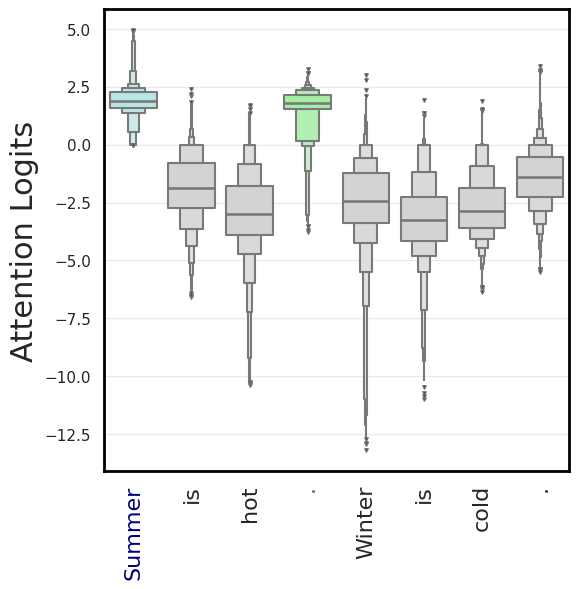

In [52]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")


attn_logits_on_test = attn_logits[:, :, -1, :]  # (B, H, N)
attn_logits_on_test = attn_logits_on_test.transpose(0, 2).flatten(1, 2)[:-1]  # (N, B*H)
df = pd.DataFrame({"Token": list(range(attn_logits_on_test.shape[0])), "Logit": to_numpy(tensor=attn_logits_on_test).tolist()}).explode("Logit")
boxenplot = sns.boxenplot(x="Token", y="Logit", data=df, palette=["paleturquoise", "lightgray", "lightgray", "palegreen", "lightgray", "lightgray", "lightgray", "lightgray"], showfliers=True, flier_kws={"marker": "v", "c":"black", "s": 6}, linewidth=1.5)
boxenplot.set_xticks(range(attn_logits_on_test.shape[0]))
boxenplot.set_xticklabels(["Summer", "is", "hot", ".", "Winter", "is", "cold", "."], rotation=90, fontsize=16)

for i, xtick in enumerate(boxenplot.get_xticklabels()):
    if i == 0:
        xtick.set_color("navy")
    elif i == 3:
        xtick.set_color("forestgreen")


plt.xlabel("", fontsize=22)
plt.ylabel("Attention Logits", fontsize=22)
plt.savefig("figures/olmo/attention_logits_on_test.pdf", bbox_inches="tight")
plt.show(fig)

In [53]:
input_tokens_shuffled = input_tokens[:, torch.randperm(input_tokens.shape[1])]
torch.save(input_tokens_shuffled, "input_tokens_shuffled.pt")

/tmp/ipykernel_641824/656314593.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_tokens_shuffled = torch.load("input_tokens_shuffled.pt")


torch.Size([1, 32, 8, 8])


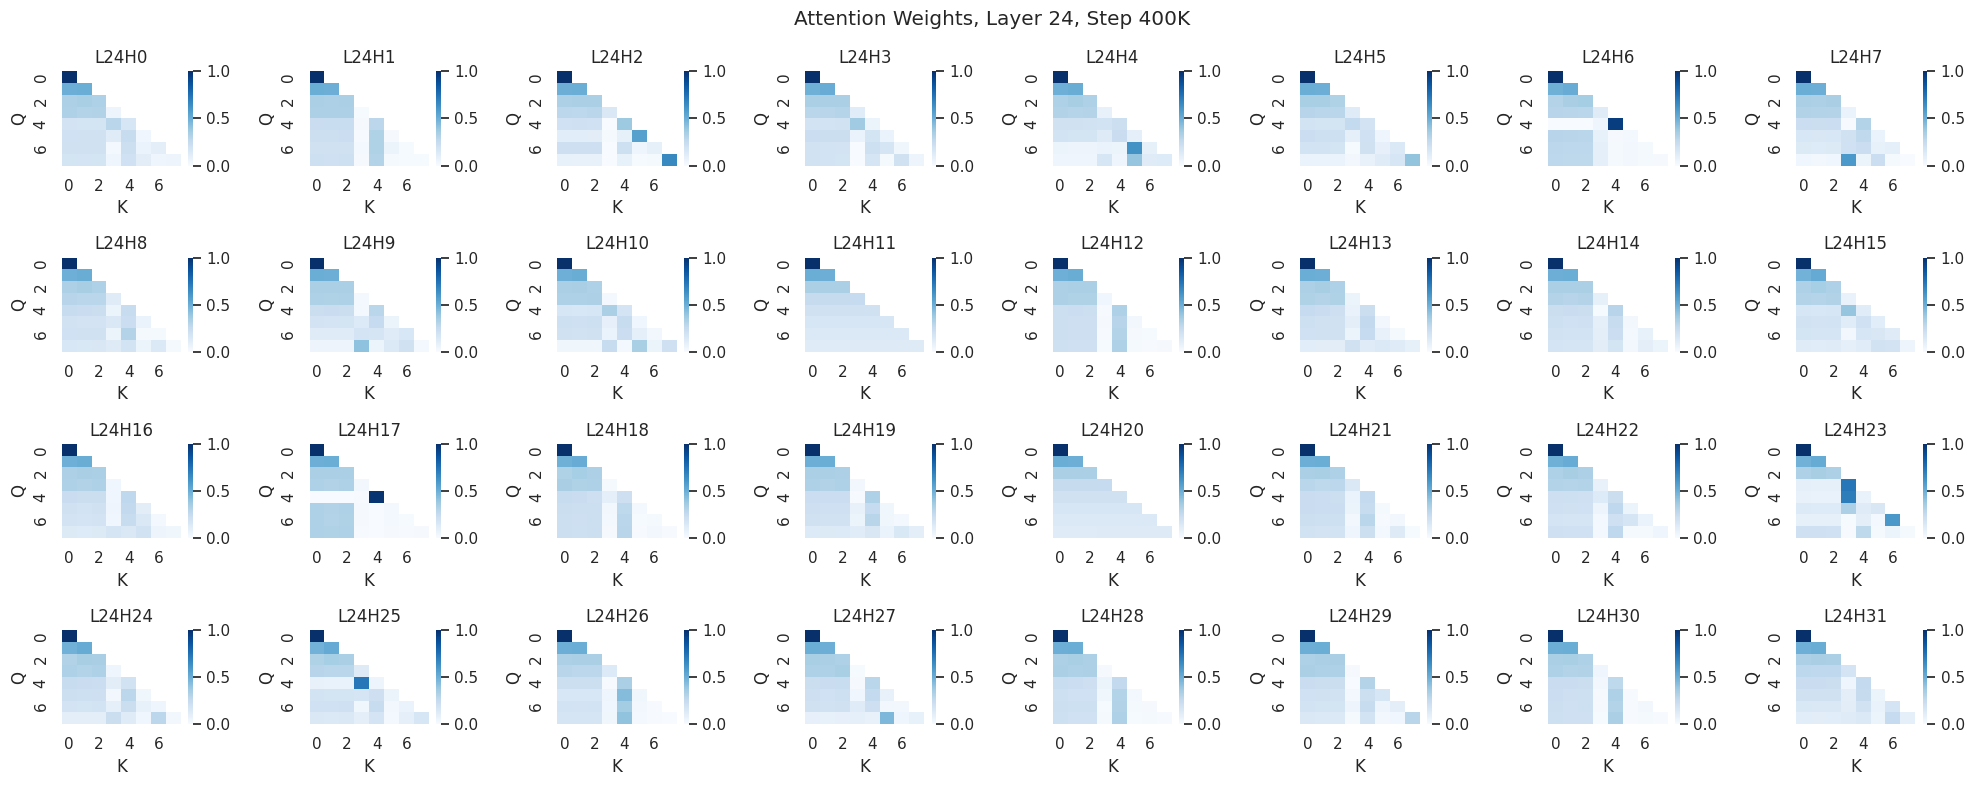

In [54]:
input_tokens_shuffled = torch.load("input_tokens_shuffled.pt")
stats = collect_statistics_at_layer(model, input_tokens_shuffled, layer_probe=layer)
attn_weights = stats["attn_weights"]
print(attn_weights.shape)
plot_heatmap_per_head(attn_weights[0], layer, "Attention Weights, Layer 24, Step 400K", "K", "Q", use_01_colorscheme=True)

In [55]:
print(input_tokens_shuffled)
input_text_shuffled = tokenizer.decode(input_tokens_shuffled.cpu().tolist()[0], clean_up_tokenization_spaces=False)
print(input_text_shuffled)
token_labels_shuffled = tokenizer.convert_ids_to_tokens(input_tokens_shuffled[0])
token_labels_shuffled_for_plot = list(map(lambda x: x.replace("Ġ", "") if x.startswith("Ġ") else x, token_labels_shuffled))
print(token_labels_shuffled)
seen_delim = False
token_colors_shuffled = []
for token_label in token_labels_shuffled:
    if token_label == "Summer":
        token_colors_shuffled.append("navy")
    elif token_label == ".":
        if seen_delim:
            token_colors_shuffled.append("black")
        else:
            token_colors_shuffled.append("forestgreen")
            seen_delim = True
    else:
        token_colors_shuffled.append("black")
print(token_colors_shuffled)

tensor([[ 5890,  5412, 46735,   310,    15,   310, 17802,    15]],
       device='cuda:2')
 warm coldSummer is. is Winter.
['Ġwarm', 'Ġcold', 'Summer', 'Ġis', '.', 'Ġis', 'ĠWinter', '.']
['black', 'black', 'navy', 'black', 'forestgreen', 'black', 'black', 'black']


/tmp/ipykernel_641824/654196992.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


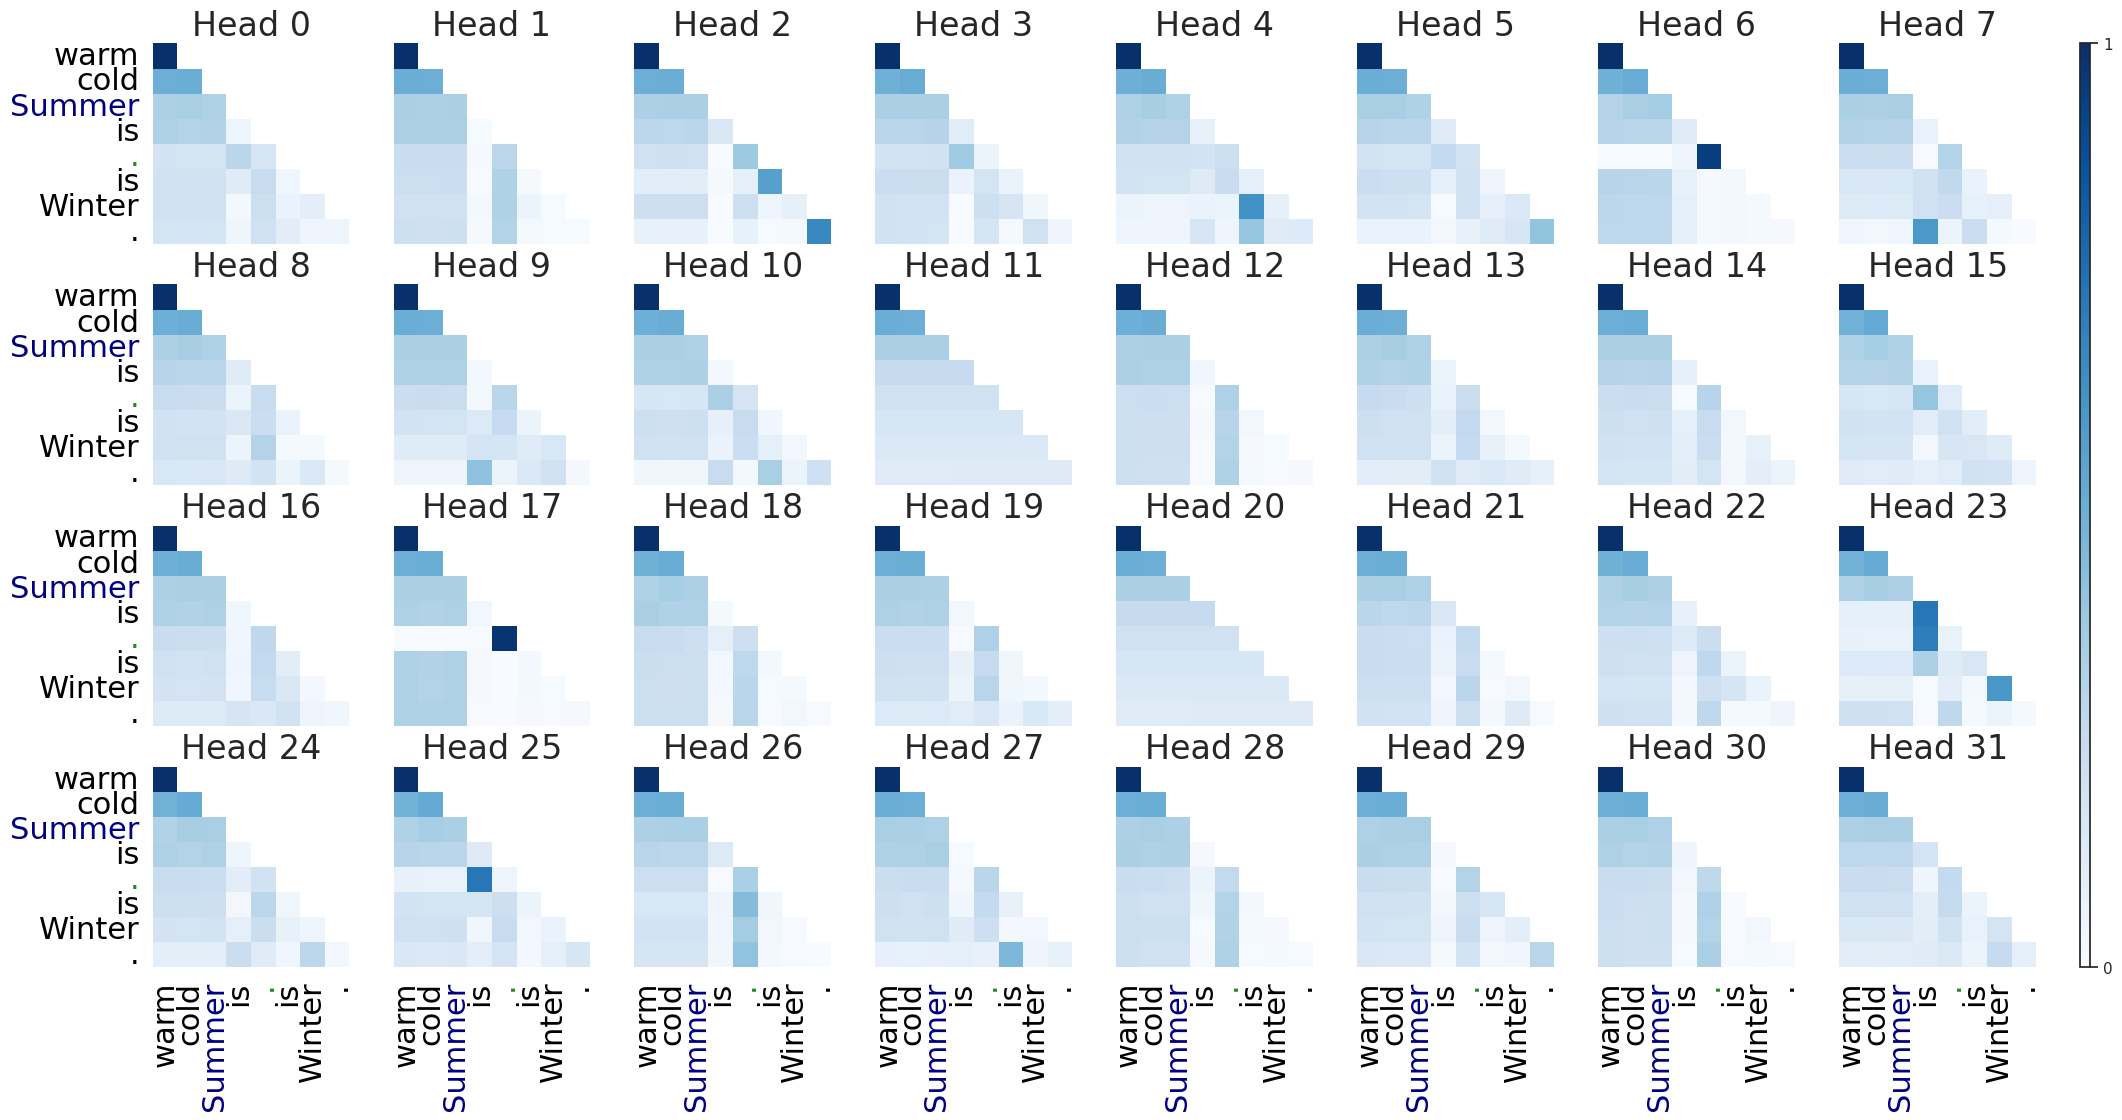

In [56]:

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

attn_weights = to_numpy(stats["attn_weights"][0])

# heads_to_plot = [19, 29, 31]
heads_to_plot = list(range(32))

fig = plt.figure(figsize=(25, 12))
gs = gridspec.GridSpec(4, 9, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 0.05], wspace=0.25)
axes = [fig.add_subplot(gs[i, j]) for i in range(4) for j in range(8)]

for head_idx, ax in zip(heads_to_plot, axes):
    heatmap = sns.heatmap(attn_weights[head_idx], cmap="Blues", ax=ax, mask=attn_weights[head_idx] == 0, vmin=0, vmax=1, cbar=False)
    ax.set_title(f"Head {head_idx}", fontsize=24)
    if head_idx >= 24:
        ax.set_xticklabels(token_labels_shuffled_for_plot)
    else:
        ax.set_xticklabels([])
    if head_idx % 8 == 0:
        ax.set_yticklabels(token_labels_shuffled_for_plot)
    else:
        ax.set_yticklabels([])
    ax.tick_params(axis='x', labelrotation=90, labelsize=22)
    ax.tick_params(axis='y', labelrotation=0, labelsize=22)

    for xtick, color in zip(ax.get_xticklabels(), token_colors_shuffled):
        xtick.set_color(color)
    for ytick, color in zip(ax.get_yticklabels(), token_colors_shuffled):
        ytick.set_color(color)

cbar_ax = fig.add_subplot(gs[:, -1])

norm = colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, ticks=[0, 1])

plt.tight_layout()
plt.show(fig)



In [57]:
from src.dataset import load_data_batches, load_dataset_from_hf
import json

dataset_name = "wikipedia"
with open("./dataset/RedPajama/wiki_texts.json") as f:
    batch = json.load(f)
inputs = tokenizer(batch, return_tensors="pt", truncation=True, max_length=64).input_ids.to(device)
inputs_batch = inputs[:128, :8]

In [58]:
layer = 24

In [59]:
recompute = True
if recompute:
    attn_weights = {}
    attn_logits = {}
    qs = {}
    ks = {}
    vs = {}
    layer_outputs = {}

    for revision in revisions_olmo:
        model = load_olmo_model(revision)
        stats = collect_statistics_at_layer(model, inputs_batch, layer_probe=layer)
        attn_weights[revision] = stats["attn_weights"]
        attn_logits[revision] = stats["attn_logits"]
        qs[revision] = stats["q_proj_postrope"]
        ks[revision] = stats["k_proj_postrope"]
        vs[revision] = stats["v_proj_postrope"]
        attn = model.model.model.layers[24].self_attn
        o_split = attn.o_proj.weight.split(attn.head_dim, dim=1)
        vo_head = torch.stack([F.linear(vs[revision][0:1, i, ...], o_split[i]) for i in range(attn.num_heads)], dim=1)
        vs[revision] = vo_head
        layer_outputs[revision] = stats["post_mlp_residual"]
        del model
        del stats
    torch.save(attn_weights, os.path.join(dir_name, "attn_weights_batch.pt"))
    torch.save(attn_logits, os.path.join(dir_name, "attn_logits_batch.pt"))
    torch.save(qs, os.path.join(dir_name, "qs_batch.pt"))
    torch.save(ks, os.path.join(dir_name, "ks_batch.pt"))
    torch.save(vs, os.path.join(dir_name, "vs_batch.pt"))
    torch.save(layer_outputs, os.path.join(dir_name, "layer_outputs_batch.pt"))

In [61]:
attn_weights = torch.load(os.path.join(dir_name, "attn_weights_batch.pt"), map_location=device)
attn_masses_on_k_tokens = {
    revision: attn_weights[revision].sum(dim=-2) / (attn_weights[revision].shape[-2] - torch.arange(attn_weights[revision].shape[-2], device=device)).reshape(1, 1, -1)
    for revision in attn_weights.keys()
}
attn_mass_on_bos_token = {
    revision: attn_masses_on_k_tokens[revision][:, :, 0]
    for revision in attn_weights.keys()
}

/tmp/ipykernel_641824/1857841769.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_weights = torch.load(os.path.join(dir_name, "attn_weights_batch.pt"), map_location=

In [62]:
sink_token_indices = {
    revision: attn_masses_on_k_tokens[revision].topk(k=2, dim=-1).indices
    for revision in attn_weights.keys()
}

In [63]:
attn_masses_on_sink_tokens = {
    revision: torch.stack(
        [
            torch.stack(
                [
                    attn_masses_on_k_tokens[revision][b, h, sink_token_indices[revision][b, h]]
                    for h in range(attn_masses_on_k_tokens[revision].shape[1])
                ],
                dim=0
            )
            for b in range(attn_masses_on_k_tokens[revision].shape[0])
        ],
        dim=0
    )
    for revision in attn_weights.keys()
}
attn_masses_on_sink_token_0 = {
    revision: attn_masses_on_sink_tokens[revision][:, :, 0]
    for revision in attn_weights.keys()
}
attn_masses_on_sink_token_1 = {
    revision: attn_masses_on_sink_tokens[revision][:, :, 1]
    for revision in attn_weights.keys()
}
total_attn_masses_on_sink_tokens = {
    revision: attn_masses_on_sink_token_0[revision] + attn_masses_on_sink_token_1[revision]
    for revision in attn_weights.keys()
}

In [64]:
print(attn_masses_on_k_tokens[revisions_olmo[-1]].shape)

torch.Size([128, 32, 8])


In [65]:
cutoff = 2.5e4
steps = np.array([revision[0] for revision in revisions_olmo])
tmp = steps[steps >= cutoff]
crucial_steps = np.isin(tmp, [cutoff, 1e5, 4e5])
tmp = np.log(tmp)
tmp = tmp - np.min(tmp)
tmp = tmp / np.max(tmp) * cutoff
tmp = tmp + cutoff
steps[steps >= cutoff] = tmp

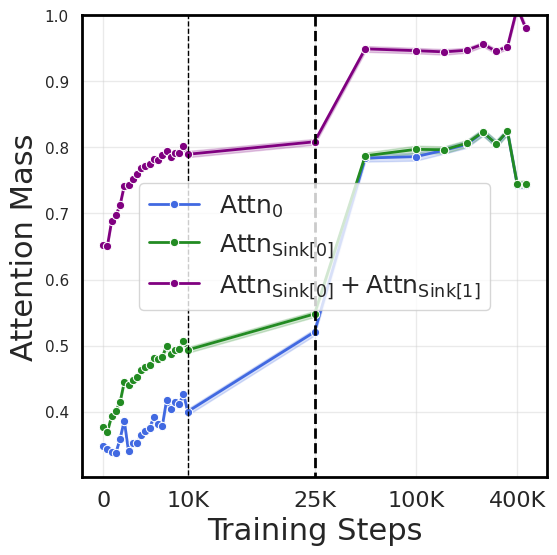

In [67]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")

df_bos = pd.DataFrame({"Step": steps, "Attention on BOS Token": [to_numpy(attn_mass_on_bos_token[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on BOS Token")
sns.lineplot(data=df_bos, x="Step", y="Attention on BOS Token", errorbar="ci", label=r"$\mathrm{Attn}_{0}$", marker="o", linewidth=2, color="royalblue")

df_sink_0 = pd.DataFrame({"Step": steps, "Attention on Sink Token 0": [to_numpy(attn_masses_on_sink_token_0[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on Sink Token 0")
sns.lineplot(data=df_sink_0, x="Step", y="Attention on Sink Token 0", errorbar="ci", label=r"$\mathrm{Attn}_{\mathrm{Sink}[0]}$", marker="o", linewidth=2, color="forestgreen")

df_sink_0_plus_1 = pd.DataFrame({"Step": steps, "Attention on Sink Token 0 + 1": [to_numpy(total_attn_masses_on_sink_tokens[revision].flatten()) for revision in revisions_olmo]}).explode(column="Attention on Sink Token 0 + 1")
sns.lineplot(data=df_sink_0_plus_1, x="Step", y="Attention on Sink Token 0 + 1", errorbar="ci", label=r"$\mathrm{Attn}_{\mathrm{Sink}[0]} + \mathrm{Attn}_{\mathrm{Sink}[1]}$", marker="o", linewidth=2, color="purple")

plt.ylabel(f"Attention Mass", fontsize=22)
plt.xlabel("Training Steps", fontsize=22)
# plt.yticks([0.7, 0.8, 0.9, 1.0], [r"$0.7$", r"$0.8$", r"$0.9$", r"$1.0$"], fontsize=16)
plt.ylim(top=1.0)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)
plt.legend(fontsize=18)
plt.savefig("figures/olmo_batch/attn_mass_on_top_two_tokens.pdf", bbox_inches="tight")
plt.show()

In [68]:
layer_outputs = torch.load(os.path.join(dir_name, "layer_outputs_batch.pt"))
layer_output_norms = {
    revision: layer_outputs[revision].norm(dim=-1)
    for revision in layer_outputs.keys()
}

/tmp/ipykernel_641824/2685461210.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  layer_outputs = torch.load(os.path.join(dir_name, "layer_outputs_batch.pt"))


In [69]:
layer_output_norms_on_bos_token = {
    revision: layer_output_norms[revision][:, 0]
    for revision in layer_output_norms.keys()
}

sorted_token_norms = {revision: torch.topk(layer_output_norms[revision], dim=-1, k=3).values for revision in layer_output_norms.keys()}
zeroth_token_norms = {revision: layer_output_norms[revision][:, 0] for revision in layer_output_norms.keys()}
top_token_norms = {revision: sorted_token_norms[revision][:, 0] for revision in sorted_token_norms.keys()}
second_token_norms = {revision: sorted_token_norms[revision][:, 1] for revision in sorted_token_norms.keys()}

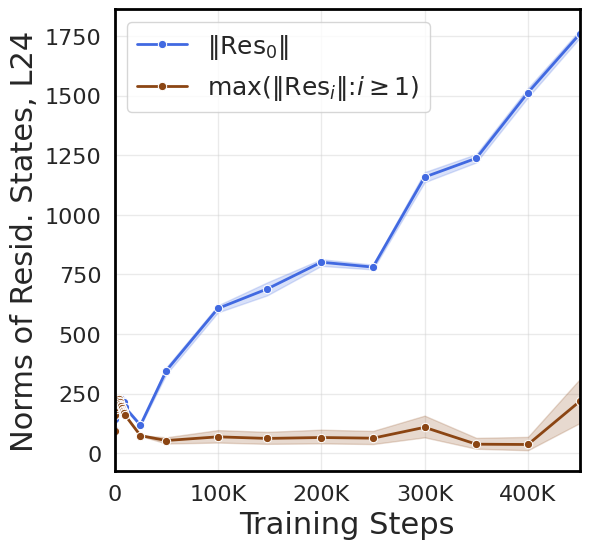

In [80]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")
df = pd.DataFrame({"Step": [revision[0] for revision in revisions_olmo], "Per-Token Output Norms": [to_numpy(zeroth_token_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Res}_{0}\|$", color="royalblue", marker="o", linewidth=2)
df = pd.DataFrame({"Step": [revision[0] for revision in revisions_olmo], "Per-Token Output Norms": [to_numpy(second_token_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\max(\|\mathrm{Res}_{i}\| \colon i \geq 1)$", color="saddlebrown", marker="o", linewidth=2)

plt.xlim(0, max([revision[0] for revision in revisions_olmo]))
plt.xlabel("Training Steps", fontsize=22)
plt.ylabel(f"Norms of Resid. States, L{layer}", fontsize=22)
plt.xticks([0, 100_000, 200_000, 300_000, 400_000], [r"$0$", r"100K", r"200K", r"300K", r"400K"], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.savefig("figures/olmo_batch/layer_output_norms.pdf", bbox_inches="tight")
plt.show()

In [72]:
attn_weights = torch.load(os.path.join(dir_name, "attn_weights_batch.pt"), map_location=device)
attn_logits = torch.load(os.path.join(dir_name, "attn_logits_batch.pt"), map_location=device)
attn_logits_valid_mask = {revision: attn_weights[revision] != 0 for revision in attn_logits.keys()}

Qk_0 = {revision: attn_logits[revision][:, :, :, 0] for revision in attn_logits.keys()}
Qk_0_normalized = {revision: 
                   torch.stack(
                       [
                           attn_logits[revision][:, :, q_idx, 0] - torch.mean(attn_logits[revision], dim=-1)[:, :, q_idx]
                           for q_idx in range(attn_logits[revision].shape[-2])
                       ], dim=-1
                   ) for revision in attn_logits.keys()}

q0_k0 = {revision: Qk_0_normalized[revision][:, :, 0] for revision in attn_logits.keys()}
qsink_k0 = {revision: torch.stack(
    [
        torch.stack(
            [
                Qk_0_normalized[revision][b, h, sink_token_indices[revision][b, h]]
                for h in range(Qk_0_normalized[revision].shape[1])
            ],
            dim=0
        )
        for b in range(Qk_0_normalized[revision].shape[0])
    ],
    dim=0
) for revision in attn_logits.keys()}

qsink0_k0 = {revision: qsink_k0[revision][:, :, 0] for revision in attn_logits.keys()}
qsink1_k0 = {revision: qsink_k0[revision][:, :, 1] for revision in attn_logits.keys()}

qnonsink_k0 = {revision: torch.stack(
    [
        torch.stack(
            [
                torch.stack([
                    Qk_0_normalized[revision][b, h, n]
                    for n in range(Qk_0_normalized[revision].shape[-1])
                    if not torch.isin(n, sink_token_indices[revision][b, h]).item()
                ],
                dim=-1)
                for h in range(Qk_0_normalized[revision].shape[1])
            ],
            dim=0
        )
        for b in range(Qk_0_normalized[revision].shape[0])
    ],
    dim=0
) for revision in attn_logits.keys()}


/tmp/ipykernel_641824/3739476587.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_weights = torch.load(os.path.join(dir_name, "attn_weights_batch.pt"), map_location=

In [73]:
qnonsink_k0[revisions_olmo[-1]].shape

torch.Size([128, 32, 6])

In [74]:
max_non_sink_token_logit = {
    revision: torch.max(qnonsink_k0[revision], dim=-1).values
    for revision in attn_logits.keys()
}
min_non_sink_token_logit = {
    revision: torch.min(qnonsink_k0[revision], dim=-1).values
    for revision in attn_logits.keys()
}
mean_non_sink_token_logit = {
    revision: torch.mean(qnonsink_k0[revision], dim=-1)
    for revision in attn_logits.keys()
}

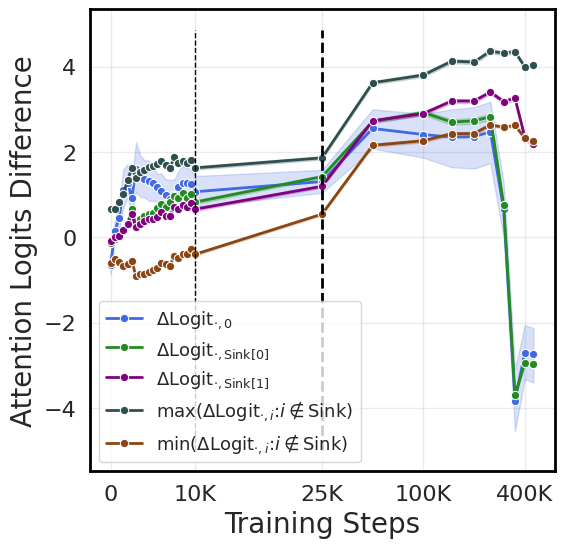

In [75]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(zeroth_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{\cdot,0}$", marker="o", linewidth=2, color="royalblue")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(qsink0_k0[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{\cdot,\mathrm{Sink}[0]}$", marker="o", linewidth=2, color="forestgreen")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(qsink1_k0[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\Delta\mathrm{Logit}_{\cdot,\mathrm{Sink}[1]}$", marker="o", linewidth=2, color="purple")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(max_non_sink_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\max(\Delta\mathrm{Logit}_{\cdot,i} \colon i \notin \mathrm{Sink})$", marker="o", linewidth=2, color="darkslategray")

df = pd.DataFrame({"Step": steps, "Attention Logits": [to_numpy(min_non_sink_token_logit[revision]).tolist() for revision in revisions_olmo]}).explode(column="Attention Logits").explode(column="Attention Logits")
sns.lineplot(data=df, x="Step", y="Attention Logits", errorbar="ci", label=r"$\min(\Delta\mathrm{Logit}_{\cdot,i} \colon i \notin \mathrm{Sink})$", marker="o", linewidth=2, color="saddlebrown")

plt.xlabel("Training Steps", fontsize=20)
# plt.xlim(1, max([revision[0] for revision in revisions_olmo]))
plt.ylabel(f"Attention Logits Difference", fontsize=20)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
ymin, ymax = ax.get_ylim()
plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
plt.savefig("figures/olmo_batch/attention_logits.pdf", bbox_inches="tight")
plt.show(fig)


In [77]:
vs = torch.load(os.path.join(dir_name, "vs_batch.pt"), map_location=device)
v_norms = {revision: vs[revision].norm(dim=-1) for revision in vs.keys()}

sink_token_v_norms = {revision: torch.stack(
    [torch.stack(
        [v_norms[revision][b, h, sink_token_indices[revision][b, h]]
        for h in range(v_norms[revision].shape[1])], dim=0
    )
    for b in range(v_norms[revision].shape[0])], dim=0
)                      
for revision in v_norms.keys()}

zeroth_token_v_norm = {revision: v_norms[revision][:, :, 0] for revision in v_norms.keys()}
sink_token_0_v_norms = {revision: sink_token_v_norms[revision][:, :, 0] for revision in v_norms.keys()}
sink_token_1_v_norms = {revision: sink_token_v_norms[revision][:, :, 1] for revision in v_norms.keys()}
nonsink_token_v_norms = {revision: torch.stack(
    [
        torch.stack(
            [
                torch.stack(
                    [
                        v_norms[revision][b, h, n]
                        for n in range(v_norms[revision].shape[-1])
                        if not torch.isin(n, sink_token_indices[revision][b, h])
                    ],
                    dim=0
                )
                for h in range(v_norms[revision].shape[1])
            ],
            dim=0
        )
        for b in range(v_norms[revision].shape[0])
    ],
    dim=0
) for revision in v_norms.keys()}

/tmp/ipykernel_641824/3786178726.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vs = torch.load(os.path.join(dir_name, "vs_batch.pt"), map_location=device)


In [78]:
nonsink_token_v_norms[revisions_olmo[-1]].shape

torch.Size([128, 32, 6])

In [79]:
zeroth_token_v_norm = {revision: v_norms[revision][:, :, 0] for revision in v_norms.keys()}
sink_token_0_v_norms = {revision: sink_token_v_norms[revision][:, :, 0] for revision in v_norms.keys()}
sink_token_1_v_norms = {revision: sink_token_v_norms[revision][:, :, 1] for revision in v_norms.keys()}
max_other_token_v_norm = {revision: torch.max(nonsink_token_v_norms[revision], dim=-1).values for revision in v_norms.keys()}
min_other_token_v_norm = {revision: torch.min(nonsink_token_v_norms[revision], dim=-1).values for revision in v_norms.keys()}

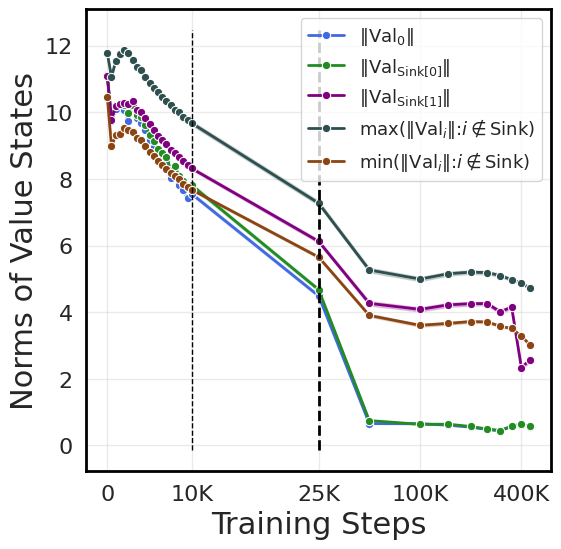

In [80]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.4)
for x in ax.spines.values():
    x.set_linewidth(2)
    x.set_color("black")


df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(zeroth_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Val}_{0}\|$", marker="o", linewidth=2, color="royalblue")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(sink_token_0_v_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Val}_{\mathrm{Sink}[0]}\|$", marker="o", linewidth=2, color="forestgreen")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(sink_token_1_v_norms[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\|\mathrm{Val}_{\mathrm{Sink}[1]}\|$", marker="o", linewidth=2, color="purple")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(max_other_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\max(\|\mathrm{Val}_{i}\| \colon i \notin \mathrm{Sink})$", marker="o", linewidth=2, color="darkslategray")

df = pd.DataFrame({"Step": steps, "Per-Token Output Norms": [to_numpy(min_other_token_v_norm[revision]).tolist() for revision in revisions_olmo]}).explode(column="Per-Token Output Norms").explode(column="Per-Token Output Norms")
sns.lineplot(data=df, x="Step", y="Per-Token Output Norms", errorbar="ci", label=r"$\min(\|\mathrm{Val}_{i}\| \colon i \notin \mathrm{Sink})$", marker="o", linewidth=2, color="saddlebrown")

plt.xlabel("Training Steps", fontsize=22)
plt.ylabel(f"Norms of Value States", fontsize=22)
plt.xticks([0, 1e4] + tmp[crucial_steps].tolist(), [r"$0$", r'10K', r'25K', r"100K", r"400K"], fontsize=16)
ymin, ymax = ax.get_ylim()
plt.vlines(x=cutoff, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=2)
plt.vlines(x=1e4, ymin=ymin, ymax=ymax, color='black', linestyle='--', linewidth=1)
# plt.xlim(0, max([revision[0] for revision in revisions_olmo]))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=13)
plt.savefig("figures/olmo_batch/value_norms.pdf", bbox_inches="tight")
plt.show(fig)

# plt.xlabel("Training Steps", fontsize=22)
# plt.ylabel(f"Norms of Value States, L{layer}", fontsize=22)
# plt.xticks([0, 100_000, 200_000, 300_000, 400_000], [r"$0$", r"100K", r"200K", r"300K", r"400K"], fontsize=16)
# plt.xlim(0, max([revision[0] for revision in revisions_olmo]))
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.legend(fontsize=18)
# plt.show(fig)